In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [3]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [4]:
dx = 7.5 
dy = 7.5
dt = 1

In [5]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [6]:
eta = f.get('eta')
eta = np.array(eta)

In [7]:
eta_flipped = np.transpose( np.flip(eta, axis= 2) , (1, 2, 0))
eta_flipped.shape

(67, 67, 1200)

In [8]:
eta = eta_flipped
eta.shape

(67, 67, 1200)

In [9]:
# new version with eta changed dimension 
def cylinder_cross_section(Spectrum, dtheta, power_Spectrum_cut , order=None):
    if order is None:
        order = 4

    Kx_2D = np.squeeze(Kx_3D[:,:,0])
    Ky_2D = np.squeeze(Ky_3D[:,:,0])
    W_1D = np.squeeze(W_3D[0,0,:])

    theta_2D = np.arctan2(-Ky_2D, -Kx_2D)
    theta_3D = np.tile(theta_2D[:, :, np.newaxis], (1, 1, W_1D.size))

    theta_vals = np.arange(-np.pi, np.pi, dtheta)
    S_cyl = np.zeros((W_1D.size, theta_vals.size))

    for ii in range(theta_vals.size):
        theta_diff = np.angle(np.exp(1j * theta_3D) * np.exp(-1j * theta_vals[ii]))
        theta_filt = np.exp(-2 * (theta_diff / dtheta) ** order)
        S_filt = power_Spectrum_cut * theta_filt
        S_cyl[:, ii] = np.nansum(S_filt, axis=(0, 1))

    thetaM, omegaM = np.meshgrid(theta_vals, W_1D)

    Scyl = {
        'P_k': S_cyl,
        'thetaM': thetaM,
        'omegaM': omegaM,
        'Kx_2D': Kx_2D, 
        'Ky_2D': Ky_2D,
        'W_1D': W_1D,
        'theta_2D':theta_2D,
        'theta_3D':theta_3D,
        'theta_vals':theta_vals,
        'theta_diff':theta_diff,
        'theta_filt':theta_filt
    }

    return Scyl

In [10]:
dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
dk

0.012503851357571316

In [11]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [12]:
Kx = spec3d.kx
Ky = spec3d.ky
w = spec3d.w

In [13]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [14]:
Norm = dKx * dKy * dW

In [15]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [18]:
power_Spectrum

array([[[0.0003803 , 0.00038039, 0.00037981, ..., 0.00038023,
         0.00038076, 0.00038051],
        [0.00038624, 0.00038567, 0.00038531, ..., 0.00038688,
         0.00038656, 0.00038527],
        [0.00039817, 0.00039769, 0.0003965 , ..., 0.00040039,
         0.00039836, 0.00039819],
        ...,
        [0.00039611, 0.00039523, 0.00039554, ..., 0.00039549,
         0.00039607, 0.00039608],
        [0.00038371, 0.00038475, 0.00038526, ..., 0.00038214,
         0.00038406, 0.00038371],
        [0.00037908, 0.00037975, 0.00037982, ..., 0.00038066,
         0.00037899, 0.00038024]],

       [[0.00039662, 0.00039677, 0.00039688, ..., 0.00039758,
         0.00039772, 0.00039724],
        [0.0004035 , 0.00040388, 0.00040219, ..., 0.00040498,
         0.0004043 , 0.00040389],
        [0.00041642, 0.00041672, 0.00041568, ..., 0.00041939,
         0.00041783, 0.00041654],
        ...,
        [0.00041015, 0.00041087, 0.00041003, ..., 0.00041099,
         0.00041064, 0.00041129],
        [0.0

# Try according to "An Algorithm for Surface Current Retrieval from X-band Marine Radar Images" Paper


In [19]:
power_Spectrum.shape

(67, 67, 1200)

## 2.2 

### High Pass Filter

In [33]:
I_0 = power_Spectrum
I_0.shape

(67, 67, 1200)

In [23]:
w_cut = 0.03 * 2*np.pi

In [28]:
Kx = spec3d.kx
Ky = spec3d.ky
w = spec3d.w

In [43]:
# Create a boolean mask based on the condition w >= w_cut
mask = (np.abs(w) >= w_cut)

In [50]:
I_1 = np.where(mask[ None, None,:], I_0, 0)

### Energy Threshold Filter

In [227]:
# Create a boolean mask based on the condition energy

P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [228]:
I_2 = np.where(condition[:, :, None], I_1, 0)

In [229]:
I_2.shape

(67, 67, 1200)

### Peak Identification

In [199]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [ ]:
    '''Function checks to see if the given spectrum slice has a peak thats is Threshold times larger or more
    than the next biggest peak. If it main peak is much larger then it is a prominent peak and it prints the 
    value of the w it occurs at
    
    Input y - Spectrum values along w axis
    
    Output w value of where the prominent peaks occurs 
    '''
    

In [416]:
def check_prominent_peaks(y):
    
        '''Function checks to see if the given spectrum slice has a peak thats is Threshold times larger or more
    than the next biggest peak. If it main peak is much larger then it is a prominent peak and it prints the 
    value of the w it occurs at
    
    Input y - Spectrum values along w axis
    
    Output w value of where the prominent peaks occurs 
    '''
    
    
    if np.max(y) < 1:
        pass
    # does nothing when y = 0
        
    else:
        peaks, _ = find_peaks(y)
        
        peak_heights = y[peaks]
        
        # Find the peak with the maximum height
        max_peak_index = np.argmax(peak_heights)
        max_peak_height = peak_heights[max_peak_index]

        threshold = 1.5

        # Check if the maximum peak 6 times larger than the others
        # If it is we conclude it is a peak on its own and print
        if max_peak_height > threshold * np.max(peak_heights[peak_heights != max_peak_height]):
            print(w[peaks][max_peak_index])
            
        else:
            pass

Text(0.5, 1.0, 'Shouldnt be counted')

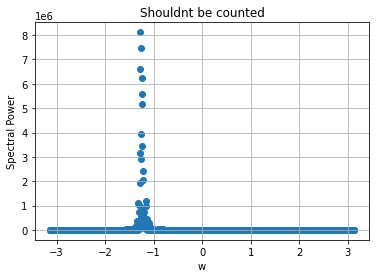

In [417]:
plt.scatter(w, I_2[40,43,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)
plt.title("Shouldnt be counted")

In [418]:
check_prominent_peaks(I_2[40,43,:])

Text(0.5, 1.0, 'Should be counted')

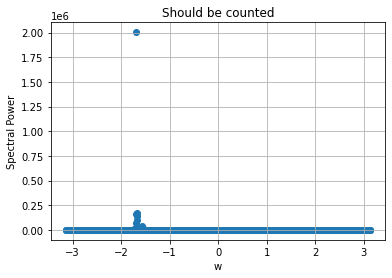

In [414]:
plt.scatter(w, I_2[14,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

plt.title("Should be counted")

In [415]:
check_prominent_peaks(I_2[14,53,:])

-1.6912240451825054


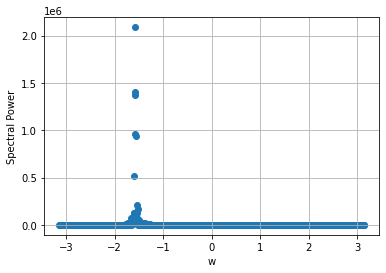

In [409]:
plt.scatter(w, I_2[22,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [410]:
check_prominent_peaks(I_2[23,53,:])

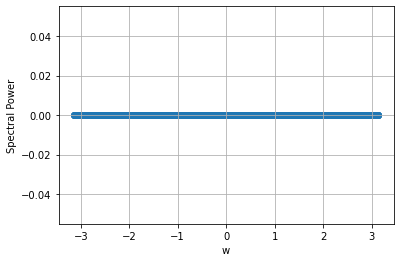

In [357]:
plt.scatter(w, I_2[10,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [375]:
check_prominent_peaks(I_2[10,53,:])

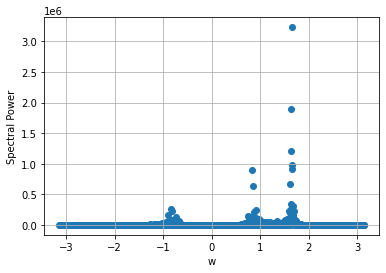

In [400]:
y = I_2[32,11,:]

plt.scatter(w, y)

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [ ]:
check_prominent_peaks(y)

In [377]:
I_2.shape

(67, 67, 1200)

In [683]:
def check_prominent_peaks(kx, ky):
    y = I_2[kx, ky,:]
    
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
        
    else:
        peak_heights = y
        
        # Find the peak with the maximum height
        max_peak_index = np.argmax(peak_heights)
        max_peak_height = peak_heights[max_peak_index]

        threshold = 6

        # Check if the maximum peak 6 times larger than the others
        # If it is we conclude it is a peak on its own and print
        if max_peak_height > threshold * np.max(peak_heights[peak_heights != max_peak_height]):
            wj[kx,ky] = w[max_peak_index]
            
        else:
            pass
            
    return wj

In [684]:
wj = check_prominent_peaks(14, 53)

In [685]:
wj[14,53]

-1.6912240451825054

In [707]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(check_prominent_peaks(kx,ky))

In [708]:
wj_array

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

In [710]:
w0 = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

Text(0.5, 1.0, 'Should be counted')

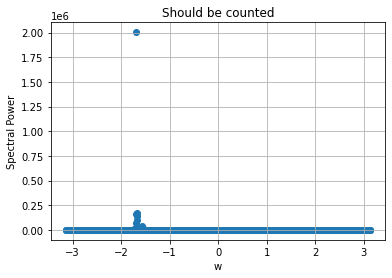

In [584]:
plt.scatter(w, I_2[14,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

plt.title("Should be counted")

In [583]:
np.max(check_prominent_peaks(14, 53))

0.0

In [563]:
for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        check_prominent_peaks(I_2[kx,ky,:])

-1.6336281798666925
-1.6336281798666925
-1.7069320084504545
-1.7174039839624204
-1.7331119472303693
-1.7645278737662673
1.7645278737662666
1.7331119472303689
1.71740398396242
1.7069320084504538
1.633628179866692
1.633628179866692


In [569]:
wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
if np.max(I_2[10,53,:]) < 1:
    wj[10,53] = 2

In [571]:
wj[10,53]

2.0

In [495]:
I_2[40,43,:]

array([21.60238418, 21.68822951, 21.77474101, ..., 21.34950362,
       21.43308125, 21.51725196])

Text(0.5, 1.0, 'Shouldnt be counted')

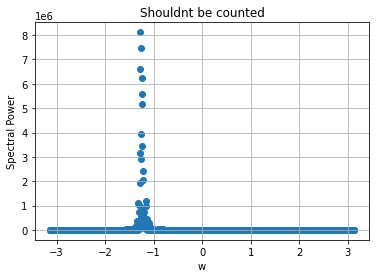

In [421]:
plt.scatter(w, I_2[40,43,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)
plt.title("Shouldnt be counted")

In [453]:
peaks, _ = find_peaks(I_2[40,43,:], distance = 10000)
peaks

array([354], dtype=int64)

In [454]:
I_2[40,43,:][354]

8118746.389151793

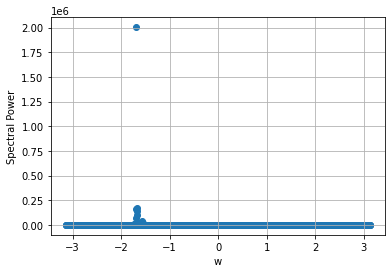

In [456]:
plt.scatter(w, I_2[14,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [457]:
peaks, _ = find_peaks(I_2[14,53,:], distance = 10000)
peaks

array([277], dtype=int64)

In [460]:
I_2[14,53,:][277]

2003483.9697088306

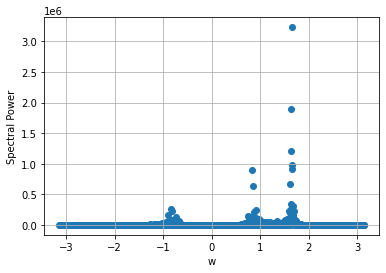

In [461]:
plt.scatter(w, I_2[32,11,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [492]:
peaks, _ = find_peaks(I_2[32,11,:], distance = 1)
peaks

array([ 203,  209,  212,  216,  220,  226,  229,  233,  236,  240,  243,
        245,  248,  250,  255,  258,  260,  262,  266,  272,  276,  278,
        281,  283,  285,  287,  290,  293,  297,  300,  303,  306,  312,
        315,  320,  323,  327,  330,  337,  339,  343,  346,  348,  350,
        353,  356,  361,  365,  367,  370,  372,  374,  379,  382,  384,
        386,  388,  391,  393,  396,  399,  403,  406,  410,  413,  418,
        420,  423,  428,  431,  434,  438,  441,  445,  449,  451,  455,
        459,  461,  466,  468,  471,  474,  478,  480,  482,  484,  486,
        488,  493,  497,  500,  502,  504,  507,  509,  514,  516,  518,
        522,  564,  681,  685,  689,  693,  697,  700,  706,  709,  714,
        716,  719,  722,  726,  728,  732,  736,  743,  745,  747,  750,
        755,  758,  761,  764,  768,  773,  776,  778,  781,  784,  786,
        788,  791,  794,  796,  799,  805,  808,  811,  815,  818,  822,
        825,  828,  830,  835,  837,  840,  844,  8

In [ ]:
I_2[32,11,:]

In [490]:
w[916]

1.6545721308906236

In [286]:
np.max(peak_heights[peak_heights != max_peak_height])

1217169.8880871974

In [295]:
np.max(peak_heights[peak_heights != max_peak_height])

1217169.8880871974

In [298]:
import heapq

In [306]:
heapq.nlargest(2, I_2[23,53,:])[1]

2468953.02973777

In [213]:
# Find peaks in the y values
peaks, _ = find_peaks(y)

threshold = 1000000

# Filter peaks based on prominence
prominences = peak_prominences(y, peaks)[0]
prominent_peaks = peaks[prominences > threshold]  # Adjust 'threshold' as needed

# Access x values corresponding to prominent peaks
prominent_x_values = w[prominent_peaks]

In [214]:
prominent_x_values

array([-1.31423293, -1.28805299, -1.26710904, -1.25140107, -1.23045712,
       -1.20951317, -1.15715329])

In [195]:
# Use NumPy to find peaks in the data
peaks, _ = find_peaks(I_2[14,53,:])

# Use the prominence parameter to filter out less prominent peaks
prominence_threshold = 0.0000000001  # You can adjust this value based on your data
prominences = np.full_like(peaks, fill_value=np.nan)

for i, peak in enumerate(peaks):
    left_base = np.argmax(I_2[14,53,:][:peak])
    right_base = np.argmax(I_2[14,53,:][peak:])
    prominences[i] = I_2[14,53,:][peak] - max(I_2[14,53,:][left_base], I_2[14,53,:][peak + right_base])

filtered_peaks = peaks[prominences > prominence_threshold]

In [196]:
filtered_peaks

array([], dtype=int64)

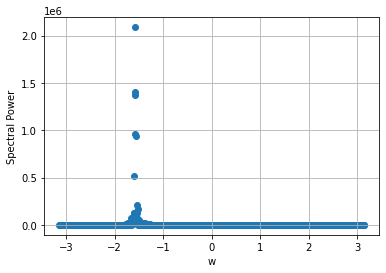

In [500]:
plt.scatter(w, I_2[22,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [511]:
I_2[22,53,:][298]

2087248.4443757373

In [523]:
indices = [0, 20 , 70, 100, 150, 200, 255, 270, 272, 292, 293, 294, 295, 296, 297, 298, 300, 301 , 302, 303, 304, 310, 320, 
           330, 340, 350, 400, 450, 500, 550, 600, 650, 700, 800, 900, 1000, 1100]

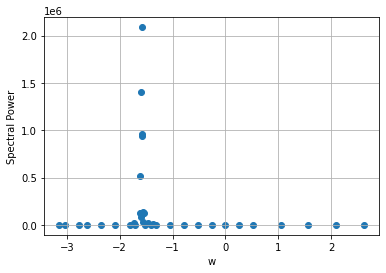

In [524]:
plt.scatter(w[indices] , I_2[22,53,:][indices])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [526]:
I_2[22,53,:][indices]

array([1.95875121e+01, 2.17955953e+01, 3.02014494e+01, 3.86345651e+01,
       6.58105570e+01, 1.46458509e+02, 8.09563221e+02, 2.21754612e+04,
       6.40104090e+02, 5.20057432e+05, 1.28551555e+05, 1.25288212e+05,
       8.11800261e+04, 1.40052558e+06, 9.64441464e+05, 2.08724844e+06,
       9.40242662e+05, 2.61656013e+04, 1.32967749e+05, 1.22127952e+05,
       1.23733666e+05, 3.60411360e+03, 2.00470602e+04, 4.04207652e+03,
       1.10741091e+04, 5.54534985e+02, 5.58959484e+01, 5.58399196e+00,
       3.91053138e+01, 2.73404280e+01, 0.00000000e+00, 1.59311017e+01,
       2.25706295e+01, 1.01049830e+02, 2.22757819e+02, 1.27038938e+01,
       1.34606021e+01])

In [525]:
w[indices]

array([-3.14159265e+00, -3.03687290e+00, -2.77507351e+00, -2.61799388e+00,
       -2.35619449e+00, -2.09439510e+00, -1.80641578e+00, -1.72787596e+00,
       -1.71740398e+00, -1.61268423e+00, -1.60744824e+00, -1.60221225e+00,
       -1.59697627e+00, -1.59174028e+00, -1.58650429e+00, -1.58126830e+00,
       -1.57079633e+00, -1.56556034e+00, -1.56032435e+00, -1.55508836e+00,
       -1.54985238e+00, -1.51843645e+00, -1.46607657e+00, -1.41371669e+00,
       -1.36135682e+00, -1.30899694e+00, -1.04719755e+00, -7.85398163e-01,
       -5.23598776e-01, -2.61799388e-01, -4.44089210e-16,  2.61799388e-01,
        5.23598776e-01,  1.04719755e+00,  1.57079633e+00,  2.09439510e+00,
        2.61799388e+00])

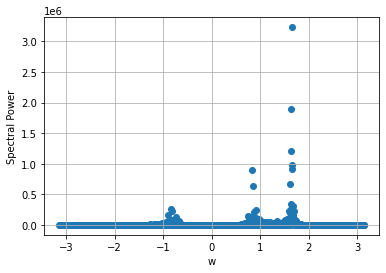

In [527]:
plt.scatter(w, I_2[32,11,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [532]:
np.argmax(I_2[32,11,:][600:900])

158

In [542]:
indices = [ 100, 200, 300, 400, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 500, 550, 600, 650, 660, 
           600, 650, 700, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 800, 850, 900, 910, 911, 912, 913, 914, 
           915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 966, 1000, 1100,]

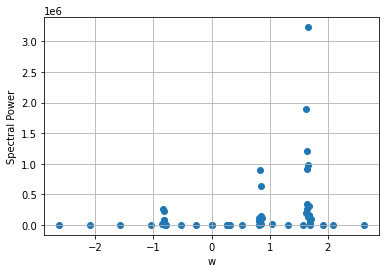

In [543]:
plt.scatter(w[indices], I_2[32,11,:][indices])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [544]:
w[indices]

array([-2.61799388e+00, -2.09439510e+00, -1.57079633e+00, -1.04719755e+00,
       -8.48230016e-01, -8.42994029e-01, -8.37758041e-01, -8.32522053e-01,
       -8.27286065e-01, -8.22050078e-01, -8.16814090e-01, -8.11578102e-01,
       -8.06342114e-01, -8.01106127e-01, -7.95870139e-01, -7.90634151e-01,
       -5.23598776e-01, -2.61799388e-01, -4.44089210e-16,  2.61799388e-01,
        3.14159265e-01, -4.44089210e-16,  2.61799388e-01,  5.23598776e-01,
        8.11578102e-01,  8.16814090e-01,  8.22050078e-01,  8.27286065e-01,
        8.32522053e-01,  8.37758041e-01,  8.42994029e-01,  8.48230016e-01,
        8.53466004e-01,  8.58701992e-01,  1.04719755e+00,  1.30899694e+00,
        1.57079633e+00,  1.62315620e+00,  1.62839219e+00,  1.63362818e+00,
        1.63886417e+00,  1.64410016e+00,  1.64933614e+00,  1.65457213e+00,
        1.65980812e+00,  1.66504411e+00,  1.67028009e+00,  1.67551608e+00,
        1.68075207e+00,  1.68598806e+00,  1.69122405e+00,  1.69646003e+00,
        1.70169602e+00,  

In [545]:
I_2[32,11,:][indices]

array([3.25876564e+00, 3.81409794e+00, 1.11474756e+03, 8.12689697e+02,
       1.20040924e+04, 9.14052161e+03, 2.39588219e+04, 2.58246107e+05,
       2.25913494e+05, 2.00792586e+04, 7.48461712e+04, 7.79328551e+04,
       1.78038258e+04, 1.24493550e+04, 2.49796877e+03, 3.03134727e+03,
       3.66156269e+02, 5.77324315e+00, 0.00000000e+00, 3.44609756e+01,
       4.28032233e+01, 0.00000000e+00, 3.44609756e+01, 4.21229883e+02,
       1.10116850e+05, 5.88833899e+04, 4.86932316e+03, 9.00693183e+05,
       4.35660173e+04, 1.12480933e+05, 6.37520293e+05, 1.45519285e+05,
       1.84586394e+04, 1.07850037e+05, 8.74590279e+03, 5.45370145e+03,
       9.68703597e+01, 1.96921122e+05, 1.89929087e+06, 2.66404045e+05,
       3.42301329e+05, 1.20854982e+06, 9.16540956e+05, 3.22951992e+06,
       9.83937935e+05, 1.27623169e+05, 1.38875057e+05, 3.03198348e+05,
       1.66383588e+05, 3.25265340e+04, 2.45382866e+03, 5.44667942e+04,
       9.83374694e+04, 2.93687201e+02, 3.75552805e+00, 4.48805516e+00])